In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install jcopdl==1.1.1
!wget https://github.com/WiraDKP/deep_learning/raw/master/16%20-%20Recurrent%20Neural%20Network/data.zip
!unzip data.zip

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12589 sha256=05ac46dad795ad629b97ebe3cd6074bb16182add3d47602a0c505dfd8e08c4d5
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
--2023-08-31 07:36:57--  https://github.com/WiraDKP/deep_learning/raw/master/16%20-%20Recurrent%20Neural%20Network/data.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WiraDKP/deep_learning/master/16%20-%20Recurrent%20Neural%20Network/data.zip [following]
--2023-08-31 07:36:57--  https://raw.githubusercontent.com/WiraDKP/deep_learning/master/16%20-%20Recurrent%20Neural%20Network/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.19

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.read_csv("/content/data/daily_min_temp.csv", parse_dates=["Date"], index_col = "Date")
df.head()

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [5]:
df = df.resample("W").mean()

<Axes: xlabel='Date'>

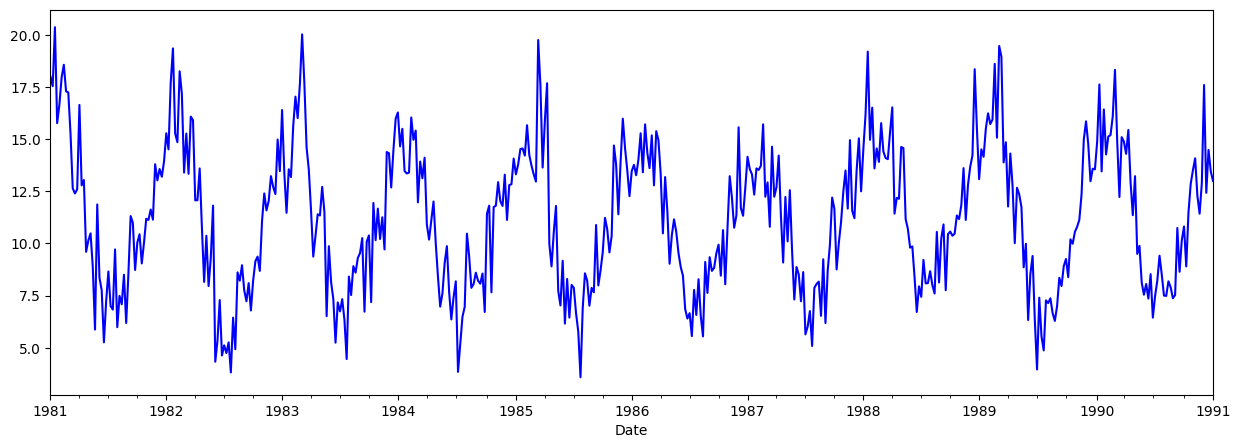

In [6]:
df.Temp.plot(figsize=(15, 5), color='b')

<h2> Dataset splitting

In [7]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

<h2> Dataset & Dataloader

In [8]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [9]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (29, 14, 1)
Note: last 11 data excluded

(N, S, F): (7, 14, 1)
Note: last 6 data excluded



<h2> Arsitektur & Config

In [10]:
from jcopdl.layers import linear_block

In [11]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True) # NFS -> N/Batch First maka True
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
         # hidden bisa tidak perlu dikeluarkan, tapi nanti di loop function tidak usah di define

In [12]:
train_set.n_feature

1

In [13]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers" : 2,
    "dropout" : 0,
    "seq_len": train_set.n_seq
})

<h2> Training Preparation -> MCOC

In [14]:
model = BiLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir="model", plot_every=100)

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        #output, hidden -> hidden bisa dibuang jika tidak digunakan
        output, hidden = model(feature, None) # inputnya ada 2, hiddennya None, maka hidden nya otomatis 0
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 132.8699 | Test_cost  = 138.3870 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 131.3963 | Test_cost  = 136.8624 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 129.9260 | Test_cost  = 135.3250 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 128.4439 | Test_cost  = 133.7614 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 126.9371 | Test_cost  = 132.1604 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 125.3944 | Test_cost  = 130.5106 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 123.8047 | Test_cost  = 128.7995 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 122.1559 | Test_cost  = 127.0140 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 120.4349 | Test_cost  = 125.1414 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 118.6293 | Test_cost  = 123.1701 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 116.7281 | Test_cost  = 121.0907 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 114.7217 | Test_cost  = 118.8958 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 112.6030 | Test_cost  = 116.5804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 110.3670 | Test_cost  = 114.1430 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 108.0120 | Test_cost  = 111.5855 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 105.5400 | Test_cost  = 108.9143 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 102.9570 | Test_cost  = 106.1404 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 100.2739 | Test_cost  = 103.2796 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 97.5062 | Test_cost  = 100.3515 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 94.6731 | Test_cost  = 97.3784 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 91.7966 | Test_cost  = 94.3831 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 88.8992 | Test_cost  = 91.3870 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 86.0020 | Test_cost  = 88.4077 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 83.1226 | Test_cost  = 85.4586 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 80.2741 | Test_cost  = 82.5476 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 77.4647 | Test_cost  = 79.6786 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 74.6980 | Test_cost  = 76.8523 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 71.9749 | Test_cost  = 74.0681 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 69.2947 | Test_cost  = 71.3254 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 66.6569 | Test_cost  = 68.6249 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 64.0622 | Test_cost  = 65.9691 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 61.5130 | Test_cost  = 63.3623 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 59.0134 | Test_cost  = 60.8104 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 56.5691 | Test_cost  = 58.3197 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 54.1863 | Test_cost  = 55.8971 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 51.8714 | Test_cost  = 53.5486 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 49.6302 | Test_cost  = 51.2797 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 47.4676 | Test_cost  = 49.0946 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 45.3876 | Test_cost  = 46.9965 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 43.3932 | Test_cost  = 44.9880 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 41.4862 | Test_cost  = 43.0702 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 39.6678 | Test_cost  = 41.2436 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 37.9382 | Test_cost  = 39.5079 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 36.2969 | Test_cost  = 37.8621 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 34.7429 | Test_cost  = 36.3050 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 33.2746 | Test_cost  = 34.8347 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 31.8903 | Test_cost  = 33.4492 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 30.5878 | Test_cost  = 32.1459 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 29.3645 | Test_cost  = 30.9220 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 28.2176 | Test_cost  = 29.7741 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 27.1437 | Test_cost  = 28.6987 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 26.1394 | Test_cost  = 27.6922 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 25.2010 | Test_cost  = 26.7511 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 24.3252 | Test_cost  = 25.8720 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 23.5084 | Test_cost  = 25.0513 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 22.7473 | Test_cost  = 24.2853 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 22.0383 | Test_cost  = 23.5705 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 21.3778 | Test_cost  = 22.9031 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 20.7624 | Test_cost  = 22.2799 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 20.1889 | Test_cost  = 21.6976 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 19.6542 | Test_cost  = 21.1535 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 19.1554 | Test_cost  = 20.6447 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 18.6902 | Test_cost  = 20.1688 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 18.2560 | Test_cost  = 19.7235 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 17.8507 | Test_cost  = 19.3066 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 17.4722 | Test_cost  = 18.9162 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 17.1187 | Test_cost  = 18.5502 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 16.7882 | Test_cost  = 18.2071 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 16.4792 | Test_cost  = 17.8851 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 16.1902 | Test_cost  = 17.5828 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 15.9197 | Test_cost  = 17.2988 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 15.6664 | Test_cost  = 17.0319 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 15.4293 | Test_cost  = 16.7810 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 15.2071 | Test_cost  = 16.5449 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 14.9989 | Test_cost  = 16.3228 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 14.8038 | Test_cost  = 16.1138 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 14.6210 | Test_cost  = 15.9170 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 14.4496 | Test_cost  = 15.7317 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 14.2889 | Test_cost  = 15.5572 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 14.1382 | Test_cost  = 15.3928 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 13.9970 | Test_cost  = 15.2380 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 13.8646 | Test_cost  = 15.0922 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 13.7406 | Test_cost  = 14.9548 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 13.6243 | Test_cost  = 14.8253 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 13.5154 | Test_cost  = 14.7034 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 13.4134 | Test_cost  = 14.5886 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 13.3179 | Test_cost  = 14.4804 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 13.1447 | Test_cost  = 14.2825 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 13.0664 | Test_cost  = 14.1922 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 12.9931 | Test_cost  = 14.1071 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 12.9246 | Test_cost  = 14.0270 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 12.8605 | Test_cost  = 13.9516 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 12.8006 | Test_cost  = 13.8806 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 12.7447 | Test_cost  = 13.8137 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 12.6924 | Test_cost  = 13.7508 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 12.6436 | Test_cost  = 13.6916 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 12.5980 | Test_cost  = 13.6359 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 12.5555 | Test_cost  = 13.5835 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 12.5158 | Test_cost  = 13.5341 | 


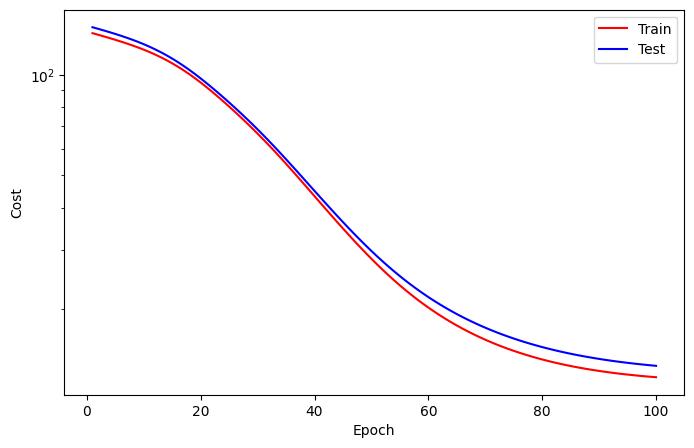

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 12.4787 | Test_cost  = 13.4877 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 12.1472 | Test_cost  = 13.0439 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 12.1351 | Test_cost  = 13.0261 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 12.1238 | Test_cost  = 13.0093 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 12.1131 | Test_cost  = 12.9934 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 12.1032 | Test_cost  = 12.9783 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 12.0938 | Test_cost  = 12.9639 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 12.0850 | Test_cost  = 12.9502 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 12.0766 | Test_cost  = 12.9371 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 12.0687 | Test_cost  = 12.9245 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 12.0611 | Test_cost  = 12.9124 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 12.0539 | Test_cost  = 12.9008 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 12.0470 | Test_cost  = 12.8896 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 11.9953 | Test_cost  = 12.8038 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 11.9915 | Test_cost  = 12.7976 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 11.9879 | Test_cost  = 12.7917 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 11.9844 | Test_cost  = 12.7861 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 11.9809 | Test_cost  = 12.7807 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 11.9774 | Test_cost  = 12.7755 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 11.9740 | Test_cost  = 12.7706 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 11.9707 | Test_cost  = 12.7660 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 11.9676 | Test_cost  = 12.7616 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 11.9645 | Test_cost  = 12.7575 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 11.9616 | Test_cost  = 12.7536 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 11.9588 | Test_cost  = 12.7499 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 11.9247 | Test_cost  = 12.7077 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 11.9223 | Test_cost  = 12.7050 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 11.9199 | Test_cost  = 12.7024 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 11.9174 | Test_cost  = 12.6998 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 11.9150 | Test_cost  = 12.6973 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 11.9126 | Test_cost  = 12.6949 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 11.9101 | Test_cost  = 12.6924 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 11.9077 | Test_cost  = 12.6900 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 11.9052 | Test_cost  = 12.6876 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 11.9028 | Test_cost  = 12.6852 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 11.9003 | Test_cost  = 12.6827 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 11.8978 | Test_cost  = 12.6803 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 11.8953 | Test_cost  = 12.6779 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 11.8748 | Test_cost  = 12.6572 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 11.8721 | Test_cost  = 12.6544 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 11.8694 | Test_cost  = 12.6517 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 11.8667 | Test_cost  = 12.6489 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 11.8640 | Test_cost  = 12.6460 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 11.8613 | Test_cost  = 12.6432 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 11.8586 | Test_cost  = 12.6403 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 11.8558 | Test_cost  = 12.6373 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 11.8530 | Test_cost  = 12.6343 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 11.8501 | Test_cost  = 12.6312 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 11.8471 | Test_cost  = 12.6280 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 11.8440 | Test_cost  = 12.6245 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 11.8408 | Test_cost  = 12.6209 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

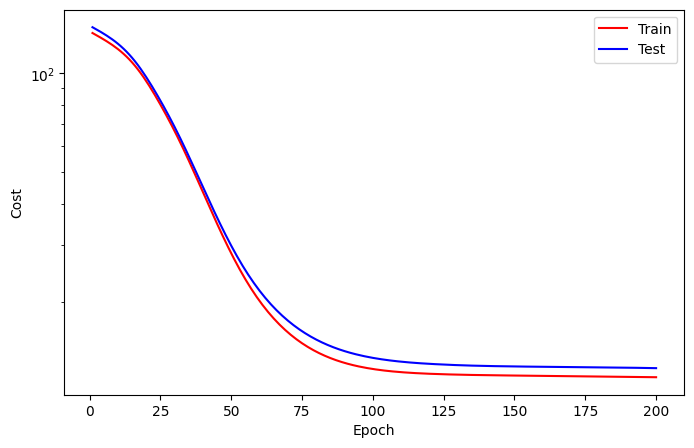

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 11.8088 | Test_cost  = 12.5859 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 11.8049 | Test_cost  = 12.5818 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 11.8013 | Test_cost  = 12.5779 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 11.7980 | Test_cost  = 12.5741 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 11.7948 | Test_cost  = 12.5702 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 11.7915 | Test_cost  = 12.5661 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 11.7881 | Test_cost  = 12.5619 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 11.7843 | Test_cost  = 12.5575 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 11.7803 | Test_cost  = 12.5531 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 11.7762 | Test_cost  = 12.5488 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 11.7720 | Test_cost  = 12.5444 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 11.7679 | Test_cost  = 12.5402 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 11.5684 | Test_cost  = 12.2993 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 11.5580 | Test_cost  = 12.2868 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 11.5472 | Test_cost  = 12.2739 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 11.5363 | Test_cost  = 12.2608 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 11.5251 | Test_cost  = 12.2473 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 11.5136 | Test_cost  = 12.2333 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 11.5016 | Test_cost  = 12.2187 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 11.4892 | Test_cost  = 12.2034 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 11.4762 | Test_cost  = 12.1874 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 11.4628 | Test_cost  = 12.1708 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 11.4491 | Test_cost  = 12.1539 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 11.4353 | Test_cost  = 12.1368 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 11.4214 | Test_cost  = 12.1197 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 9.9518 | Test_cost  = 10.3821 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 9.8854 | Test_cost  = 10.3008 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 9.8094 | Test_cost  = 10.2096 | 


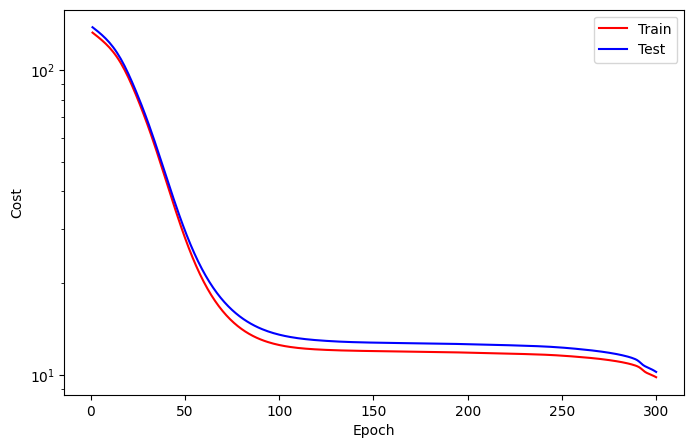

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 9.7226 | Test_cost  = 10.1098 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 9.6248 | Test_cost  = 10.0008 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 9.5190 | Test_cost  = 9.8796 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 9.4082 | Test_cost  = 9.7491 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 9.2947 | Test_cost  = 9.6166 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 9.1806 | Test_cost  = 9.4834 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 9.0642 | Test_cost  = 9.3450 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 8.9433 | Test_cost  = 9.2029 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 8.8176 | Test_cost  = 9.0604 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 8.6881 | Test_cost  = 8.9137 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 6.1875 | Test_cost  = 6.1555 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 6.0623 | Test_cost  = 6.0337 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 5.9429 | Test_cost  = 5.9037 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 5.8283 | Test_cost  = 5.7636 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 5.7159 | Test_cost  = 5.6290 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 5.6074 | Test_cost  = 5.5044 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 5.5015 | Test_cost  = 5.3895 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 5.4002 | Test_cost  = 5.2693 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 5.3031 | Test_cost  = 5.1499 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 5.2118 | Test_cost  = 5.0489 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 5.1243 | Test_cost  = 4.9424 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 5.0412 | Test_cost  = 4.8332 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 3.7588 | Test_cost  = 3.3116 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 3.7285 | Test_cost  = 3.2738 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 3.6971 | Test_cost  = 3.2258 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 3.6557 | Test_cost  = 3.1868 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 3.6268 | Test_cost  = 3.1550 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 3.6000 | Test_cost  = 3.1164 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 3.5653 | Test_cost  = 3.0832 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   369
Train_cost  = 3.5382 | Test_cost  = 3.0573 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   370
Train_cost  = 3.5140 | Test_cost  = 3.0241 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   371
Train_cost  = 3.4835 | Test_cost  = 2.9973 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   372
Train_cost  = 3.4610 | Test_cost  = 2.9746 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   373
Train_cost  = 3.4376 | Test_cost  = 2.9441 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   374
Train_cost  = 3.4116 | Test_cost  = 2.9168 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   399
Train_cost  = 2.9682 | Test_cost  = 2.4565 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   400
Train_cost  = 2.9551 | Test_cost  = 2.4475 | 


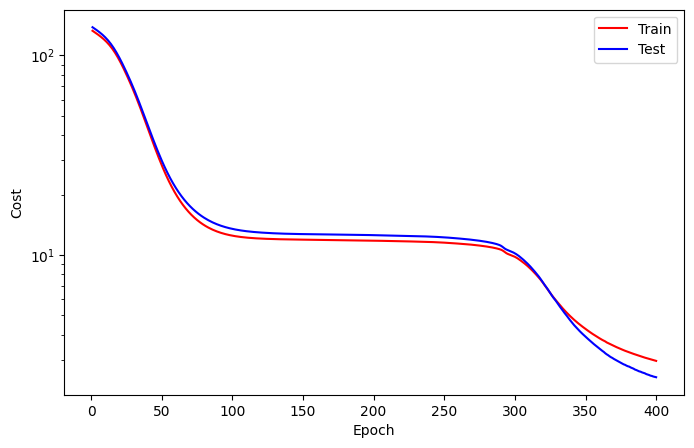

Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   401
Train_cost  = 2.9424 | Test_cost  = 2.4295 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   402
Train_cost  = 2.9300 | Test_cost  = 2.4224 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   403
Train_cost  = 2.9175 | Test_cost  = 2.4057 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   404
Train_cost  = 2.9054 | Test_cost  = 2.3922 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   405
Train_cost  = 2.8934 | Test_cost  = 2.3814 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   406
Train_cost  = 2.8817 | Test_cost  = 2.3667 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   407
Train_cost  = 2.8701 | Test_cost  = 2.3627 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   408
Train_cost  = 2.8587 | Test_cost  = 2.3446 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   409
Train_cost  = 2.8474 | Test_cost  = 2.3431 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   410
Train_cost  = 2.8363 | Test_cost  = 2.3233 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   411
Train_cost  = 2.8254 | Test_cost  = 2.3227 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 2.6139 | Test_cost  = 2.1116 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 2.6054 | Test_cost  = 2.1282 | 
==> EarlyStop patience =  1 | Best test_cost: 2.1116


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 2.5961 | Test_cost  = 2.1120 | 
==> EarlyStop patience =  2 | Best test_cost: 2.1116


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   437
Train_cost  = 2.5878 | Test_cost  = 2.0934 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   438
Train_cost  = 2.5810 | Test_cost  = 2.1148 | 
==> EarlyStop patience =  1 | Best test_cost: 2.0934


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   439
Train_cost  = 2.5745 | Test_cost  = 2.0769 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   440
Train_cost  = 2.5670 | Test_cost  = 2.0966 | 
==> EarlyStop patience =  1 | Best test_cost: 2.0769


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   441
Train_cost  = 2.5587 | Test_cost  = 2.0731 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   442
Train_cost  = 2.5505 | Test_cost  = 2.0677 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   443
Train_cost  = 2.5432 | Test_cost  = 2.0745 | 
==> EarlyStop patience =  1 | Best test_cost: 2.0677


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   444
Train_cost  = 2.5366 | Test_cost  = 2.0455 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   445
Train_cost  = 2.5301 | Test_cost  = 2.0688 | 
==> EarlyStop patience =  1 | Best test_cost: 2.0455


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   446
Train_cost  = 2.5233 | Test_cost  = 2.0342 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   498
Train_cost  = 2.2447 | Test_cost  = 1.8396 | 
==> EarlyStop patience =  1 | Best test_cost: 1.8209


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   499
Train_cost  = 2.2408 | Test_cost  = 1.8163 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   500
Train_cost  = 2.2368 | Test_cost  = 1.8308 | 


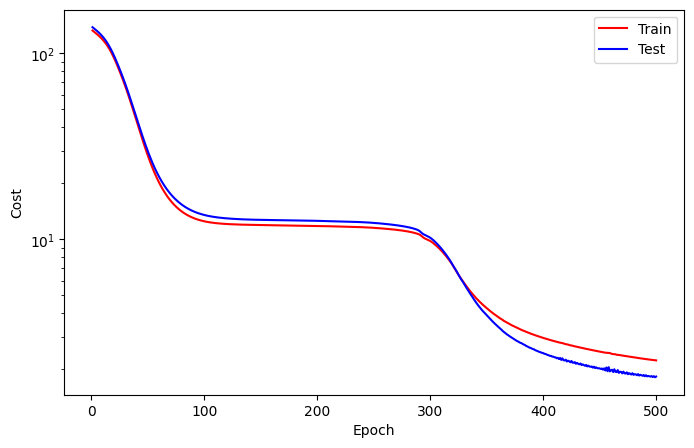

==> EarlyStop patience =  1 | Best test_cost: 1.8163


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   501
Train_cost  = 2.2327 | Test_cost  = 1.8157 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   502
Train_cost  = 2.2287 | Test_cost  = 1.8205 | 
==> EarlyStop patience =  1 | Best test_cost: 1.8157


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   503
Train_cost  = 2.2248 | Test_cost  = 1.8173 | 
==> EarlyStop patience =  2 | Best test_cost: 1.8157


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   504
Train_cost  = 2.2210 | Test_cost  = 1.8107 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   505
Train_cost  = 2.2173 | Test_cost  = 1.8178 | 
==> EarlyStop patience =  1 | Best test_cost: 1.8107


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   506
Train_cost  = 2.2138 | Test_cost  = 1.8033 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   507
Train_cost  = 2.2102 | Test_cost  = 1.8169 | 
==> EarlyStop patience =  1 | Best test_cost: 1.8033


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   508
Train_cost  = 2.2067 | Test_cost  = 1.7983 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   509
Train_cost  = 2.2032 | Test_cost  = 1.8135 | 
==> EarlyStop patience =  1 | Best test_cost: 1.7983


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   510
Train_cost  = 2.1996 | Test_cost  = 1.7946 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   528
Train_cost  = 2.1455 | Test_cost  = 1.7421 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   529
Train_cost  = 2.1448 | Test_cost  = 1.8406 | 
==> EarlyStop patience =  1 | Best test_cost: 1.7421


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   530
Train_cost  = 2.1468 | Test_cost  = 1.7272 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   531
Train_cost  = 2.1477 | Test_cost  = 1.8784 | 
==> EarlyStop patience =  1 | Best test_cost: 1.7272


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   532
Train_cost  = 2.1504 | Test_cost  = 1.7237 | 


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   533
Train_cost  = 2.1418 | Test_cost  = 1.8072 | 
==> EarlyStop patience =  1 | Best test_cost: 1.7237


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   534
Train_cost  = 2.1309 | Test_cost  = 1.7659 | 
==> EarlyStop patience =  2 | Best test_cost: 1.7237


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   535
Train_cost  = 2.1237 | Test_cost  = 1.7299 | 
==> EarlyStop patience =  3 | Best test_cost: 1.7237


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   536
Train_cost  = 2.1261 | Test_cost  = 1.8371 | 
==> EarlyStop patience =  4 | Best test_cost: 1.7237


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   537
Train_cost  = 2.1292 | Test_cost  = 1.7287 | 
==> EarlyStop patience =  5 | Best test_cost: 1.7237
==> Execute Early Stopping at epoch: 537 | Best test_cost: 1.7237
==> Best model is saved at model


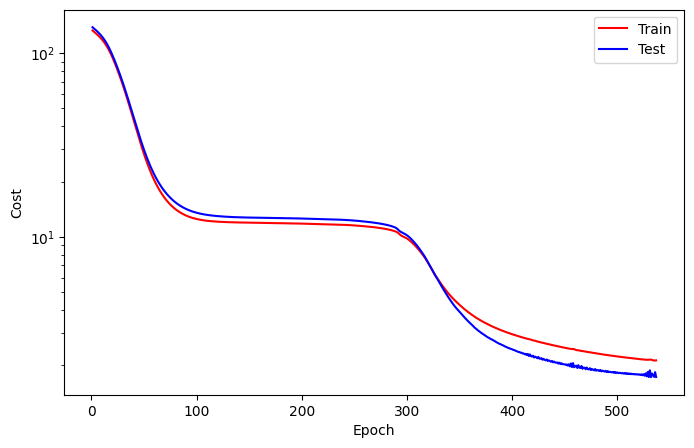

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

<h2> Forecast

In [17]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()

def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1) # forecasting jadi per 1 data, input 1 pred 1
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

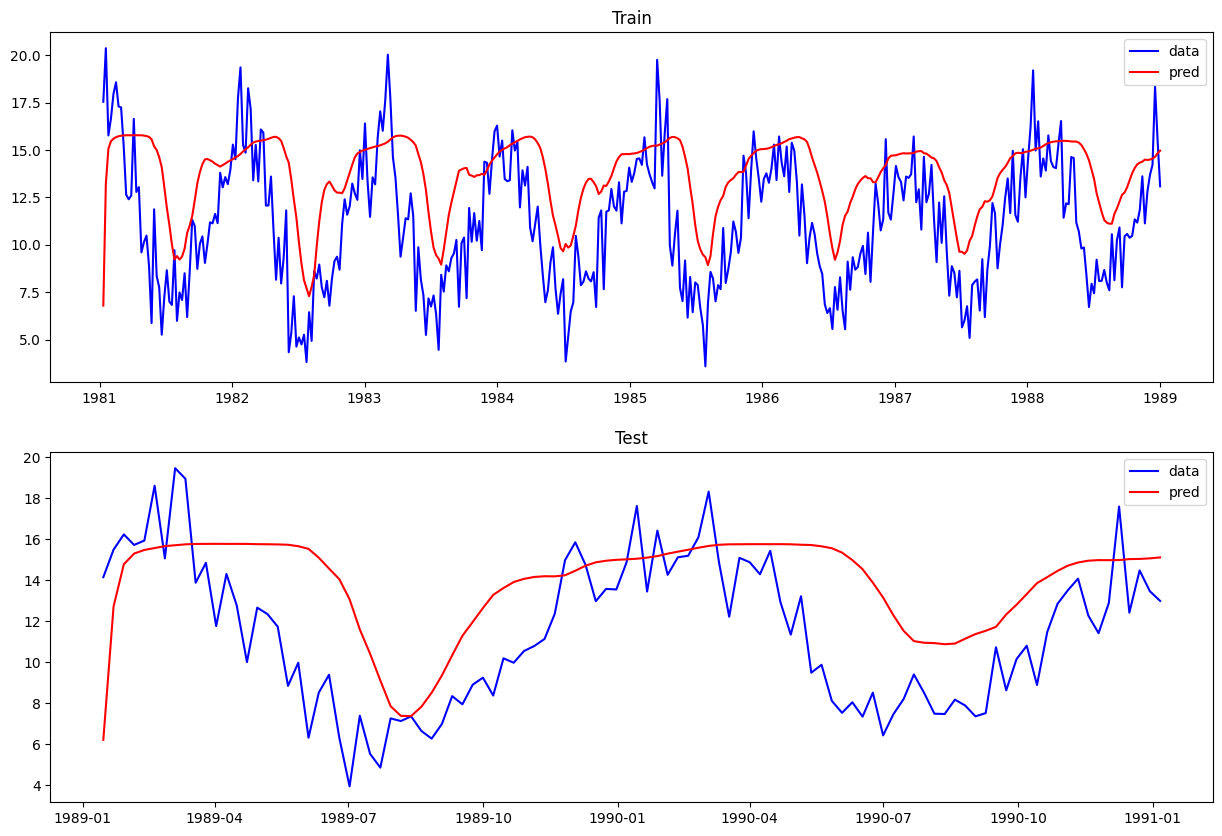

In [19]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

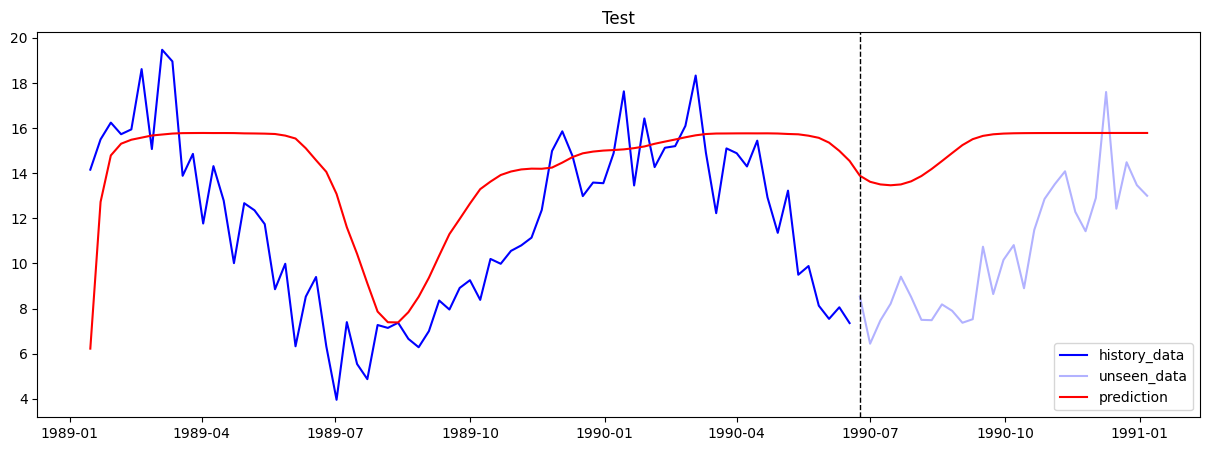

In [20]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")